In [1]:
#load the data and split it into train set, test set (and splits the labels for the test set)
import pandas as pd
data = pd.read_csv("datasets/ckd.csv")
data["CKD_Stage"] -= 1 #converts the stages from 1-5 to 0-4
from sklearn.model_selection import train_test_split
full_train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
labels_stage = full_train_set["CKD_Stage"].copy()
labels_progression = full_train_set["CKD_Progression"].copy()
full_train_set = full_train_set.drop(labels=["CKD_Stage", "CKD_Progression", "CKD_Risk"], axis=1)

In [2]:
#scales the data and fills in missing values with the median
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('std_scaler', MinMaxScaler()),
])
full_train_set = num_pipeline.fit_transform(full_train_set)

In [3]:
#splits the scaled data into training and validation
train_set = full_train_set[:800]
validation_set = full_train_set[800:]
train_labels_s = labels_stage[:800]
validation_labels_s = labels_stage[800:]
train_labels_p = labels_progression[:800]
validation_labels_p = labels_progression[800:]

# Progressão
Vamos ver como uma arquitetura de ANN consegue classificar a progressão de um paciente.
Essa ANN consiste de 2 camadas FC com 200 neurônios cada, com regularização l2. A camada de output é um único neurônio, que gera como output a probabilidade (entre 0 a 1) da doênça de um paciente estar progredindo

In [4]:
from tensorflow import keras
input_ = keras.Input(shape=full_train_set[0].shape)
hidden1 = keras.layers.Dense(200, activation="relu", kernel_regularizer=keras.regularizers.l2(0.03))(input_)
hidden2 = keras.layers.Dense(200, activation="relu", kernel_regularizer=keras.regularizers.l2(0.03))(hidden1)
output_progression = keras.layers.Dense(1, activation="sigmoid", name="Progression")(hidden2)
model_progression = keras.Model(inputs=[input_], outputs=[output_progression])

model_progression.compile(loss=["binary_crossentropy"],
optimizer="sgd",
metrics=["accuracy", "precision", "recall", "f1_score", "auc"])

model_progression.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Progression (Dense)             │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,601 (174.22 KB)

 Trainable params: 44,601 (174.22 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model_progression.fit(train_set, train_labels_p,epochs=500,validation_data=(validation_set, validation_labels_p))

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6272 - auc: 0.4592 - f1_score: 0.3774 - loss: 7.6968 - precision: 0.2301 - recall: 0.2404 - val_accuracy: 0.8000 - val_auc: 0.3915 - val_f1_score: 0.3333 - val_loss: 7.4536 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7751 - auc: 0.4342 - f1_score: 0.3668 - loss: 7.3995 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8000 - val_auc: 0.4186 - val_f1_score: 0.3333 - val_loss: 7.2136 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7786 - auc: 0.4968 - f1_score: 0.3624 - loss: 7.1695 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8000 - val_auc: 0.5005 - val_f1_score: 0.3333 - val_loss: 6.9979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7777 - auc: 0.5696 - f1_score: 0.3630 - loss:

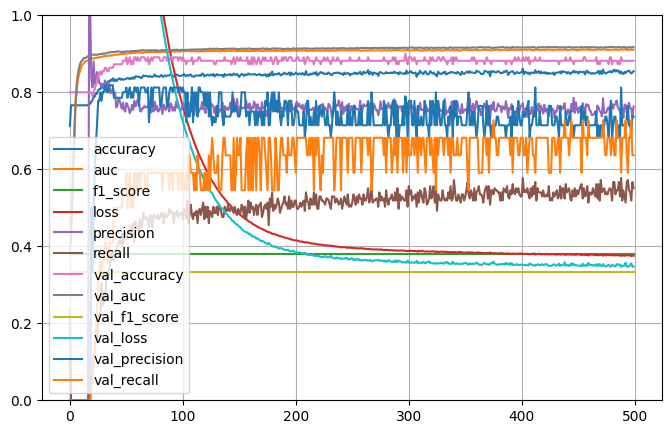

In [6]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = (model_progression.predict(num_pipeline.fit_transform(test_set.drop(labels=["CKD_Stage", "CKD_Progression", "CKD_Risk"], axis=1))) > 0.5)
y_test = test_set["CKD_Progression"].copy()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in sorted(list(test_set["CKD_Progression"].unique()))]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       157
           1       0.72      0.41      0.52        71

    accuracy                           0.77       228
   macro avg       0.75      0.67      0.68       228
weighted avg       0.76      0.77      0.75       228

Confusion Matrix:
[[146  11]
 [ 42  29]]


Esse modelo não parece ser muito bom na classificação binária.

# Estágio
Agora vamos ver como essa mesma arquitetura se desempenha em classificar o estágio do paciente (entre 2 e 5). A camade de output binária é trocada por uma camada de output com 5 neurônios e ativação softmax.

In [8]:
input_ = keras.Input(shape=full_train_set[0].shape)
hidden1 = keras.layers.Dense(200, activation="relu", kernel_regularizer=keras.regularizers.l2(0.03))(input_)
hidden2 = keras.layers.Dense(200, activation="relu", kernel_regularizer=keras.regularizers.l2(0.03))(hidden1)
output_stage = keras.layers.Dense(5, activation="softmax", name="Stage")(hidden2)
model_stage = keras.Model(inputs=[input_], outputs=[output_stage])

model_stage.compile(loss=["sparse_categorical_crossentropy"],
optimizer="sgd",
metrics=["accuracy"])
model_stage.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Stage (Dense)                   │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,405 (177.36 KB)

 Trainable params: 45,405 (177.36 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model_stage.fit(train_set, train_labels_s,epochs=500,validation_data=(validation_set, validation_labels_s))

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3615 - loss: 8.5073 - val_accuracy: 0.4545 - val_loss: 8.2670
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4571 - loss: 8.1592 - val_accuracy: 0.3909 - val_loss: 8.0051
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4439 - loss: 7.8933 - val_accuracy: 0.4273 - val_loss: 7.7749
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4572 - loss: 7.6779 - val_accuracy: 0.4364 - val_loss: 7.5611
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4481 - loss: 7.4631 - val_accuracy: 0.4364 - val_loss: 7.3578
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4861 - loss: 7.2508 - val_accuracy: 0.4364 - val_loss: 7.1629
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5026 - loss: 7.0512 - val_accuracy: 0.4364 - val_loss: 6.9746
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5310 - loss: 6.8822 - val_accuracy: 0.4545 - 

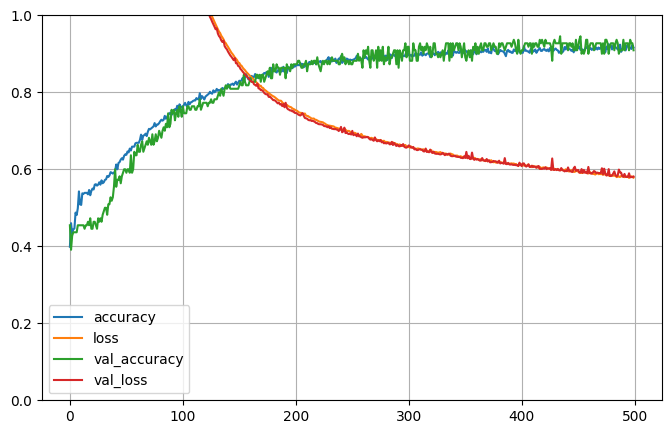

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
y_pred = np.argmax(model_stage.predict(num_pipeline.fit_transform(test_set.drop(labels=["CKD_Stage", "CKD_Progression", "CKD_Risk"], axis=1))), axis=1)
y_test = test_set["CKD_Stage"].copy()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c+1) for c in sorted(list(test_set["CKD_Stage"].unique()))]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Classification Report:
              precision    recall  f1-score   support

           2       0.89      1.00      0.94        17
           3       0.96      0.98      0.97        94
           4       0.89      0.94      0.92        70
           5       1.00      0.83      0.91        47

    accuracy                           0.94       228
   macro avg       0.94      0.94      0.93       228
weighted avg       0.94      0.94      0.94       228

Confusion Matrix:
[[17  0  0  0]
 [ 2 92  0  0]
 [ 0  4 66  0]
 [ 0  0  8 39]]


O modelo tem um resultado bem melhor nessa tarefa.